In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pywt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pandas as pd

In [2]:
_IMG_PATH = '../images/lena512.bmp'

In [3]:
img = cv2.imread(_IMG_PATH)
img.shape

(512, 512, 3)

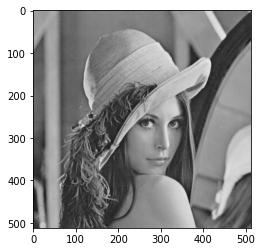

In [4]:
plt.imshow(img)

In [5]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img_gray

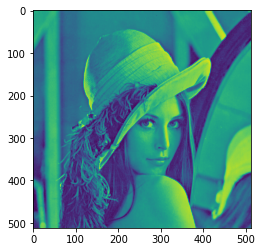

In [6]:
plt.imshow(img_gray)

In [7]:
def add_noisy(img, var=None):
    """
    create a noise array with the same size as the input image
    add noise array into the input image
    """
    row,col= img.shape
    mean = 0
    if not var:
        var = 25
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = img + gauss
    return noisy, gauss

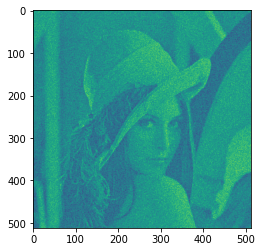

In [8]:
img_noise, noise = add_noisy(img_gray, var=50**2)
plt.imshow(img_noise)

In [9]:
def transform_wavelet(spatial):
    coeffs2 = pywt.dwt2(spatial, 'db2')
    return coeffs2

In [10]:
y_coeffs = transform_wavelet(img_noise)
x_coeffs = transform_wavelet(img_gray)
v_coeffs = transform_wavelet(noise)

In [11]:
def visu_shrink(img_noise, var_noise_est):
    sigma_noise_est = var_noise_est**0.5
    thres = sigma_noise_est*np.sqrt(2*np.log10(img_noise.shape[0]*img_noise.shape[1]))
    return thres

In [12]:
var_noise_est = np.median(np.abs(y_coeffs[-1][-1]))/0.6745
var_noise_est

49.993011630933886

In [13]:
thres = visu_shrink(img_noise, var_noise_est)

In [14]:
def soft_thresholding(coeff, thres):
    coeff_thres = np.zeros((coeff.shape[0],coeff.shape[1]))
    for i in range(coeff.shape[0]):
        for j in range(coeff.shape[1]):
            sgn = coeff[i][j]/np.abs(coeff[i][j])
            thres_func = np.maximum((np.abs(coeff[i][j]) - thres), 0)
            coeff_thres[i][j] = sgn*thres_func
    return coeff_thres

In [ ]:
thres

In [17]:
def denoising_by_threshold(coeffs_origin, coeffs_w_noise, thres):
    ll, (lh, hl, hh) = coeffs_w_noise
    
    lh_w_thres = soft_thresholding(lh, thres)
    hl_w_thres = soft_thresholding(hl, thres)
    hh_w_thres = soft_thresholding(hh, thres)
    
    ll_origin, (lh_origin, hl_origin, hh_origin) = coeffs_origin
    
    coeff_w_thres = ll, (lh_w_thres, hl_w_thres, hh_w_thres)
    
    mse_lh = mean_squared_error(lh_origin, lh_w_thres)
    mse_hl = mean_squared_error(hl_origin, hl_w_thres)
    mse_hh = mean_squared_error(hh_origin, hh_w_thres)
    
    mse_sum = mse_lh + mse_hl + mse_hh
    
    return mse_sum, coeff_w_thres

## Context variable

In [18]:
def denoise_multi_process(args):
    coeffs_origin, coeffs_w_noise, thres = args
    mse,_ = denoising_by_threshold(coeffs_origin, coeffs_w_noise, thres)
    return mse

In [19]:
mse, coeff_w_thres = denoising_by_threshold(x_coeffs, y_coeffs, thres)

In [20]:
mse

3374.137365340527

In [21]:
img_denoise = pywt.waverec2(coeff_w_thres, 'db2')

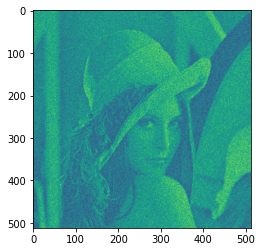

In [22]:
plt.imshow(img_denoise)

In [23]:
def PSNR(img_origin, img_denoise):
    mse = np.mean((img_origin - img_denoise) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [24]:
PSNR(img_gray, img_noise),PSNR(img_gray, img_denoise)

(14.163762453535089, 16.46353953800837)